In [3]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [4]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using JuMP
using COSMO
using OSQP
using Printf

In [5]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [6]:
#Quadrotor parameters
m = 0.03
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
thrustToTorque = 0.005964552
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8


h = 1/50 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [7]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = Q*v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
  ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [8]:
#Goal state
uhover = (0.5)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [9]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [10]:
#LQR Controller
# K = dlqr(Ã,B̃,Q,R)
#Feedback controller
function controller_lqr(x, k)
    
  q0 = x0[4:7]
  q = x[4:7]
  ϕ = qtorp(L(q0)'*q)
  
  Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
  
  u = uhover - K*Δx̃
end

controller_lqr (generic function with 1 method)

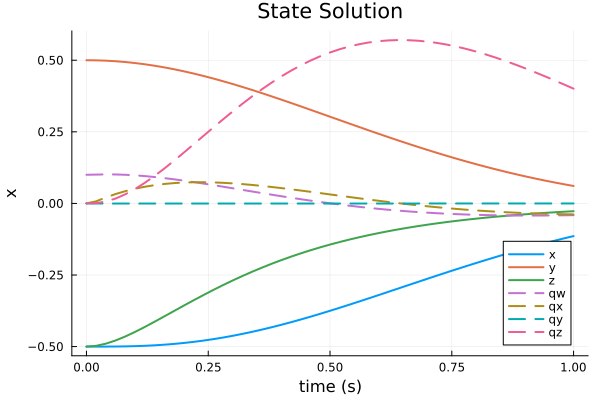

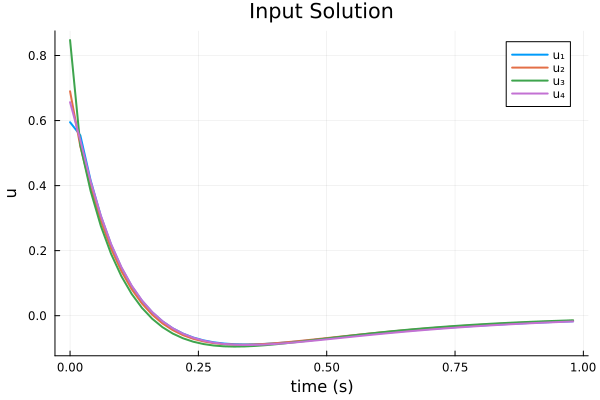

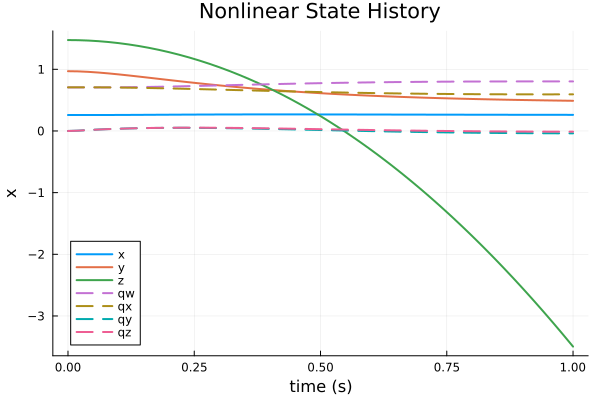

ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    1.082e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0


In [15]:
#Feedback hovering controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
nx = Nx̃
nu = Nu
N = 51
dt = h
t_vec = h*(0:N-1)
Δx̃g = zeros(Nx̃)
Xref = [deepcopy(Δx̃g) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

u_min = -1*uhover
u_max =  1*uhover

x_min = -100.0*ones(nx)
# x_min[1:7] .= -.8
x_max = 100.0*ones(nx)
# x_max[1:7] .= 1.0

# Cost weights
Q = Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]);
R = Array(I(Nu));

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

P = [zeros(nx,nx) for i = 1:100]   # cost to go quadratic term
p = [zeros(nx) for i = 1:100]      # cost to go linear term
d = [zeros(nu) for i = 1:100-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:100-1] # feedback gain

P[100] = Q
for k = (100-1):-1:1
    K[k] .= (R + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã)
    P[k] .= Q + Ã'*P[k+1]*(Ã - B̃*K[k])
end
Qf = P[1]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Xref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [ones(nu) for k = 1:N-1]
X1 = [zeros(nx) for i = 1:N]
U1 = [ones(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

# optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
#         "verbose"=>false,
#         "eps_abs"=>1e-4,
#         "eps_rel"=>1e-4,
#         "rho"=>1e-2,
#         "scaling"=>0,
#         "alpha"=>1.0)
optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "eps_prim_inf"=>1e-4,
        "eps_dual_inf"=>1e-4)
        # "rho"=>1e-2,
        # "scaling"=>0,
        # "alpha"=>1.0,)   

Random.seed!(12);
x = [rg+rand(3); L(qg)*rptoq([1; 0; 0]); vg; ωg];
q = x[4:7]
ϕ = qtorp(L(qg)'*q)    
Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
X[1] .= [-0.5; 0.5; -0.5; 0.1; 0; 0; 0; 0; 0; 0; 0; 0]
X1[1] .= X[1]
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# u = mpc_JuMP!(optimizer, params, X1, U1, Ã, B̃, 0.0; warm_start=true)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],U[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))             

In [ ]:
for k = 1:N-1
  display(U[k]')
  display(U1[k]')
end

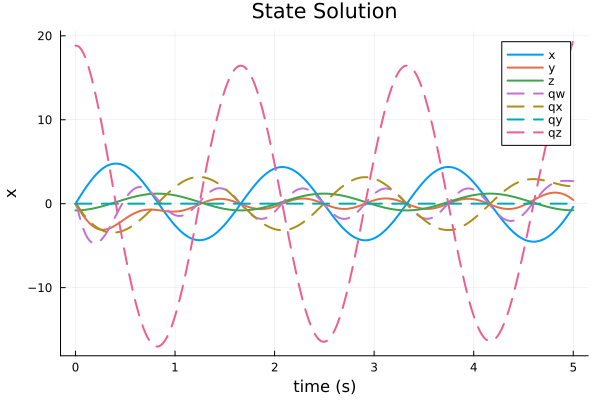

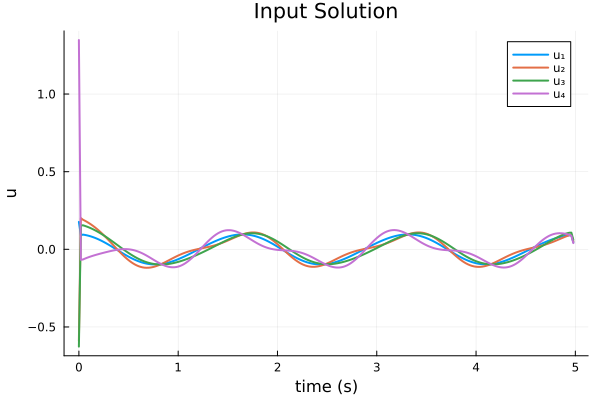

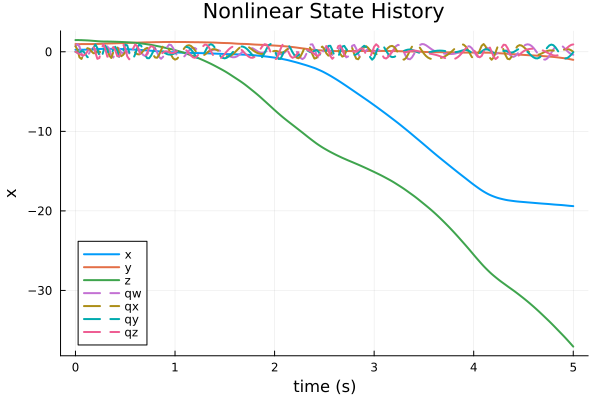

ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    2.670e+05   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 0


In [9]:
#Feedback tracking controller
include("tinyMPC.jl")
nx = Nx̃
nu = Nu
N = Nt
dt = h

# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:Nt]
Uref = [zeros(nu) for i = 1:Nt-1]
Xref = [[5*cos(t);5*cos(t)*sin(t);1.2+sin(t);1;zeros(9)] for t = range(-pi/2, 3*pi/2 + 4*pi, length = Nt)]
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    rref = Xref[k][1:3]
    qref = Xref[k][4:7]
    vref = Xref[k][8:10]
    ωref = Xref[k][11:13]
    ϕ = qtorp(L(qg)'*qref)    
    Δx̃ref[k] .= [-xg[1:3]+rref; ϕ; -xg[8:10]+vref; -xg[11:13]+ωref]
end
u_min = -uhover
u_max =  0.8*uhover

# state is x y v θ
x_min = -ones(nx)
x_max = ones(nx)

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

X[1] .= Δx̃ref[1]
u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# Open-loop Simulation
xhist = zeros(Nx,N)
xhist[:,1] = x
for k = 1:(N-1)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
end

# Plots
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="Nonlinear State History", xlabel="time (s)", ylabel="x"))   

In [10]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
nx = Nx̃
nu = Nu
N = 21
dt = h
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt+N]
Δx̃ref = [zeros(nx) for i = 1:Nt+N]
Uref = [zeros(nu) for i = 1:Nt+N-1]

# Number-eight
Xref = [[5*cos(t);5*cos(t)*sin(t);1;1;zeros(9)] for t = range(0, 2*pi + pi/4, length = Nt+N)]  

# Triangle
p0 = [0; 0; 1.0]; p1 = [3; 2; 2.]; p2 = [6; 0; 2.]; p3 = [0; 0; 1.0]
range1 = collect(LinRange(p0, p1, round(Int,(Nt+N)/3)))
range2 = collect(LinRange(p1, p2, round(Int,(Nt+N)/3)))
range3 = collect(LinRange(p2, p3, round(Int,(Nt+N)/3)+1))
range123 = [range1; range2; range3]
for k = 1:Nt+N
    Xref[k][1:3] .= range123[k]
end

for i = 1:Nt+N-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt+N
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -0.7*uhover
u_max =  0.7*uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.3
x_max = 100*ones(nx)
x_max[3] = 0.3

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = 10*Q, R = R, Qf = 10*Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = Uref, dt = dt,
);
# optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
#         "verbose"=>false,
#         "eps_abs"=>1e-4,
#         "eps_rel"=>1e-4,
#         "rho"=>1e-2,
#         "scaling"=>0,
#         "alpha"=>1.0)
optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-2,
        "eps_rel"=>1e-2,
        "eps_prim_inf"=>1e-2,
        "eps_dual_inf"=>1e-2)
        # "rho"=>1e-2,
        # "scaling"=>0,
        # "alpha"=>1.0,)        
# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)
    
P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    u = mpc_JuMP(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)
    # @time u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=10,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0)
    return u + uhover
end

controller_mpc (generic function with 1 method)

In [11]:
#Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3); L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*1
for k = 1:(Nt-1)
    params1 = (; params..., Uref = Uref[k:N+k-1], Xref = Δx̃ref[k:N+k])  # update ref
    shift_fill(U)
    uhist[k] = controller_mpc(params1, xhist[k], k)
    uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  9.840696 seconds (22.20 M allocations: 1.274 GiB, 4.16% gc time, 1.08% compilation time)


  0.003577 seconds (10.59 k allocations: 1.512 MiB)
  0.003291 seconds (10.55 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003527 seconds (10.62 k allocations: 1.522 MiB)
  0.002563 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002645 seconds (10.62 k allocations: 1.523 MiB)
  0.002573 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002955 seconds (10.62 k allocations: 1.522 MiB)
  0.002612 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002664 seconds (10.62 k allocations: 1.522 MiB)
  0.002499 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002650 seconds (10.62 k allocations: 1.522 MiB)
  0.002603 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002617 seconds (10.62 k allocations: 1.523 MiB)
  0.002637 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002639 seconds (10.62 k allocations: 1.522 MiB)
  0.002604 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002799 seconds (10.62 k allocations: 1.522 MiB)
  0.002509 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002680 seconds (10.62 k allocations: 1.522 MiB)
  0.002641 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002619 seconds (10.62 k allocations: 1.523 MiB)
  0.002782 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002667 seconds (10.62 k allocations: 1.522 MiB)
  0.002897 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002596 seconds (10.62 k allocations: 1.522 MiB)
  0.002472 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002641 seconds (10.62 k allocations: 1.522 MiB)
  0.002563 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002591 seconds (10.62 k allocations: 1.523 MiB)
  0.002467 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002770 seconds (10.62 k allocations: 1.522 MiB)
  0.002829 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002769 seconds (10.62 k allocations: 1.522 MiB)
  0.002700 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002586 seconds (10.62 k allocations: 1.522 MiB)
  0.002844 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002589 seconds (10.62 k allocations: 1.523 MiB)
  0.002783 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002745 seconds (10.62 k allocations: 1.522 MiB)
  0.002927 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002561 seconds (10.62 k allocations: 1.522 MiB)
  0.002542 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003103 seconds (10.62 k allocations: 1.522 MiB)
  0.002632 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002644 seconds (10.62 k allocations: 1.523 MiB)
  0.002556 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002594 seconds (10.62 k allocations: 1.522 MiB)
  0.002687 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002641 seconds (10.62 k allocations: 1.522 MiB)
  0.002485 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002824 seconds (10.62 k allocations: 1.522 MiB)
  0.002874 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002596 seconds (10.62 k allocations: 1.523 MiB)
  0.002457 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002656 seconds (10.62 k allocations: 1.522 MiB)
  0.002627 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002590 seconds (10.62 k allocations: 1.522 MiB)
  0.002545 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002728 seconds (10.62 k allocations: 1.522 MiB)
  0.002712 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004047 seconds (10.62 k allocations: 1.523 MiB)
  0.002590 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002896 seconds (10.62 k allocations: 1.522 MiB)
  0.002710 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002693 seconds (10.62 k allocations: 1.522 MiB)
  0.002566 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002645 seconds (10.62 k allocations: 1.522 MiB)
  0.002608 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002695 seconds (10.62 k allocations: 1.523 MiB)
  0.002961 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002744 seconds (10.62 k allocations: 1.522 MiB)
  0.002602 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003732 seconds (10.62 k allocations: 1.522 MiB)
  0.002571 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002635 seconds (10.62 k allocations: 1.522 MiB)
  0.002770 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002714 seconds (10.62 k allocations: 1.522 MiB)
  0.002650 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002737 seconds (10.62 k allocations: 1.522 MiB)
  0.002729 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002600 seconds (10.62 k allocations: 1.522 MiB)
  0.002531 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002693 seconds (10.62 k allocations: 1.522 MiB)
  0.002606 seconds (10.54 k allocations: 1.508 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002738 seconds (10.62 k allocations: 1.522 MiB)
  0.002587 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002630 seconds (10.62 k allocations: 1.522 MiB)
  0.002668 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002590 seconds (10.62 k allocations: 1.522 MiB)
  0.002718 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003400 seconds (10.62 k allocations: 1.522 MiB)
  0.003269 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004278 seconds (10.62 k allocations: 1.522 MiB)
  0.004597 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003538 seconds (10.62 k allocations: 1.522 MiB)
  0.002950 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002614 seconds (10.62 k allocations: 1.522 MiB)
  0.002568 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002657 seconds (10.62 k allocations: 1.522 MiB)
  0.002661 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002641 seconds (10.62 k allocations: 1.522 MiB)
  0.002710 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002672 seconds (10.62 k allocations: 1.522 MiB)
  0.002782 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004163 seconds (10.62 k allocations: 1.522 MiB)
  0.002650 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002656 seconds (10.62 k allocations: 1.522 MiB)
  0.003731 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002666 seconds (10.62 k allocations: 1.522 MiB)
  0.002460 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002693 seconds (10.62 k allocations: 1.522 MiB)
  0.002865 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002885 seconds (10.62 k allocations: 1.522 MiB)
  0.002604 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002655 seconds (10.62 k allocations: 1.522 MiB)
  0.003157 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002694 seconds (10.62 k allocations: 1.522 MiB)
  0.002659 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002742 seconds (10.62 k allocations: 1.522 MiB)
  0.002669 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003033 seconds (10.62 k allocations: 1.522 MiB)
  0.002652 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002727 seconds (10.62 k allocations: 1.522 MiB)
  0.003853 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002804 seconds (10.62 k allocations: 1.522 MiB)
  0.002775 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002667 seconds (10.62 k allocations: 1.522 MiB)
  0.002643 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002697 seconds (10.62 k allocations: 1.522 MiB)
  0.002608 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002646 seconds (10.62 k allocations: 1.522 MiB)
  0.002898 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002607 seconds (10.62 k allocations: 1.522 MiB)
  0.002567 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002741 seconds (10.62 k allocations: 1.522 MiB)
  0.002589 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002592 seconds (10.62 k allocations: 1.522 MiB)
  0.002650 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003000 seconds (10.62 k allocations: 1.522 MiB)
  0.002669 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002629 seconds (10.62 k allocations: 1.522 MiB)
  0.002601 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002693 seconds (10.62 k allocations: 1.522 MiB)
  0.002609 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002674 seconds (10.62 k allocations: 1.522 MiB)
  0.002704 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002761 seconds (10.62 k allocations: 1.522 MiB)
  0.002614 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002744 seconds (10.62 k allocations: 1.522 MiB)
  0.002562 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002709 seconds (10.62 k allocations: 1.522 MiB)
  0.002734 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002600 seconds (10.62 k allocations: 1.522 MiB)
  0.002594 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002730 seconds (10.62 k allocations: 1.522 MiB)
  0.002766 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002677 seconds (10.62 k allocations: 1.522 MiB)
  0.002584 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002683 seconds (10.62 k allocations: 1.522 MiB)
  0.002644 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002656 seconds (10.62 k allocations: 1.522 MiB)
  0.002573 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002702 seconds (10.62 k allocations: 1.522 MiB)
  0.002813 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002650 seconds (10.62 k allocations: 1.522 MiB)
  0.002650 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002787 seconds (10.62 k allocations: 1.521 MiB)
  0.004362 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002646 seconds (10.62 k allocations: 1.521 MiB)
  0.002579 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002577 seconds (10.62 k allocations: 1.521 MiB)
  0.002703 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002869 seconds (10.62 k allocations: 1.522 MiB)
  0.002774 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002726 seconds (10.62 k allocations: 1.521 MiB)
  0.002506 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002606 seconds (10.62 k allocations: 1.521 MiB)
  0.002547 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002854 seconds (10.62 k allocations: 1.521 MiB)
  0.002906 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002730 seconds (10.62 k allocations: 1.521 MiB)
  0.002573 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002735 seconds (10.62 k allocations: 1.521 MiB)
  0.002901 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.004081 seconds (10.62 k allocations: 1.521 MiB)
  0.002591 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002622 seconds (10.62 k allocations: 1.521 MiB)
  0.002665 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002670 seconds (10.62 k allocations: 1.521 MiB)
  0.002586 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002755 seconds (10.62 k allocations: 1.521 MiB)
  0.002603 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002668 seconds (10.62 k allocations: 1.521 MiB)
  0.002585 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002627 seconds (10.62 k allocations: 1.521 MiB)
  0.002648 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002935 seconds (10.62 k allocations: 1.521 MiB)
  0.002599 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002907 seconds (10.62 k allocations: 1.521 MiB)
  0.002930 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002658 seconds (10.62 k allocations: 1.521 MiB)
  0.002555 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002703 seconds (10.62 k allocations: 1.521 MiB)
  0.002580 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002820 seconds (10.62 k allocations: 1.521 MiB)
  0.002758 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002875 seconds (10.62 k allocations: 1.521 MiB)
  0.002614 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002605 seconds (10.62 k allocations: 1.521 MiB)
  0.002571 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002653 seconds (10.62 k allocations: 1.521 MiB)
  0.002916 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002679 seconds (10.62 k allocations: 1.521 MiB)
  0.002832 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003206 seconds (10.62 k allocations: 1.521 MiB)
  0.003078 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002535 seconds (10.62 k allocations: 1.521 MiB)
  0.002520 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002641 seconds (10.62 k allocations: 1.521 MiB)
  0.004580 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002545 seconds (10.62 k allocations: 1.521 MiB)
  0.002573 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002739 seconds (10.62 k allocations: 1.521 MiB)
  0.002538 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002767 seconds (10.62 k allocations: 1.521 MiB)
  0.002683 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002779 seconds (10.62 k allocations: 1.521 MiB)
  0.002702 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002704 seconds (10.62 k allocations: 1.521 MiB)
  0.002688 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.003084 seconds (10.62 k allocations: 1.521 MiB)
  0.002731 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002708 seconds (10.62 k allocations: 1.521 MiB)
  0.002676 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002702 seconds (10.62 k allocations: 1.521 MiB)
  0.002742 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002621 seconds (10.62 k allocations: 1.521 MiB)
  0.002597 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002619 seconds (10.62 k allocations: 1.521 MiB)
  0.002666 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002738 seconds (10.62 k allocations: 1.521 MiB)
  0.002674 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002840 seconds (10.62 k allocations: 1.521 MiB)
  0.002610 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002614 seconds (10.62 k allocations: 1.521 MiB)
  0.002592 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002835 seconds (10.62 k allocations: 1.521 MiB)
  0.002651 seconds (10.54 k allocations: 1.507 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290
┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


  0.002610 seconds (10.62 k allocations: 1.521 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


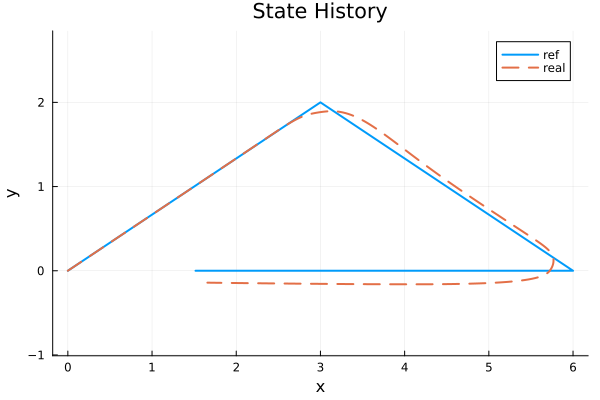

In [12]:
Xsim_m = mat_from_vec(Xref[1:Nt])
plot(Xsim_m[1,:],Xsim_m[2,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="x", ylabel="y")
Xsim_m = mat_from_vec(xhist[1:Nt])   
display(plot!(Xsim_m[1,:],Xsim_m[2,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="x", ylabel="y", aspect_ratio=:equal))

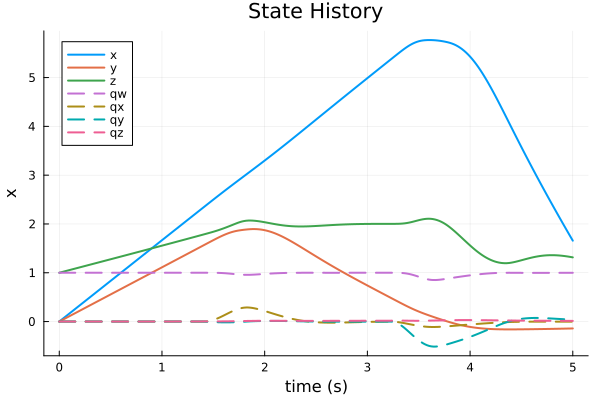

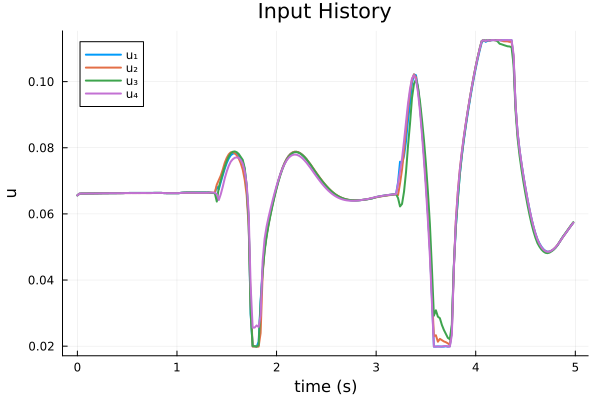

In [13]:
Xsim_m = mat_from_vec(xhist[1:Nt])   
Usim_m = mat_from_vec(uhist[1:Nt-1])   
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))